<a href="https://colab.research.google.com/github/3803531/Projet-POO-Python-jeux-de-soci-t-1000-bornes/blob/main/Cherif_IGUI_TP2_BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 $$ \text{Sorbonne universite}$$
$$ \text{Biometrie}$$
$$ \text{TP2 - Implémentation d’une cascade de régresseurs pour
l’alignement de points caractéristiques du visage.  }$$
$$ \text{Cherif IGUI }$$
$$ \text{ 2022/2023 }$$

"**Remarque** : ce TP a été réalisé sur Google Colab sous forme de notebook, comprenant les réponses aux questions. Cela a été fait pour réduire le temps de calcul."

**L'objectif** de ce TP est de développer une méthode d'alignement de points caractéristiques du visage en utilisant du code Python.

## 1. Préparation des données

## Utils python

In [ ]:
pip install opencv-python==4.5.1.48 opencv-contrib-python==4.5.1.48

In [27]:

# importer les librairies
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
from google.colab.patches import *

## 1.1 Téléchargement des données

* Cette commande utilise wget, un outil en ligne de commande permettant de télécharger des fichiers à partir d'Internet. Elle télécharge le fichier à l'adresse URL spécifiée ("https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download") dans le répertoire courant.

In [ ]:
!wget https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download 

Ce code permet de décompresser un fichier zip qui a été téléchargé dans le répertoire '/content/download'. Pour ce faire, il utilise la bibliothèque zipfile de Python qui permet de lire et d'écrire des fichiers zip.

In [ ]:
!unzip "/content/download" -d "/content/data_300"

## **1.2 Visualisation des données**


In [30]:
"""   Cette fonction affiche plusieurs images en utilisant la bibliothèque de visualisation Matplotlib de Python.
 Elle prend en entrée une liste d'images en entrée (img_in), une liste d'images en sortie (img_out) et
 une liste d'indices d'images (img_idx) à afficher.      """

def disp(img_in, img_out, img_idx):
    num_img = len(img_idx)
    plt.figure(figsize=(18, 4))
    for i, image_idx in enumerate(img_idx):
        # on trace l'image originale
        ax = plt.subplot(2, num_img, i + 1)
        plt.imshow(img_in[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Ce code ouvre un fichier texte contenant des chemins d'accès vers des images et lit toutes les lignes du fichier. Il utilise ensuite la méthode split('\n') pour séparer chaque ligne en une entrée distincte dans une liste. La méthode pop() est utilisée pour supprimer le dernier élément de la liste, qui est généralement une ligne vide à la fin du fichier.

Le code imprime également le nom du fichier de points caractéristiques associé à la deuxième image de la liste en utilisant la méthode ligne[1][:-3]+'pts'. Cette méthode supprime les trois derniers caractères du nom de fichier d'image (c'est-à-dire '.jpg') et ajoute '.pts' à la fin du nom de fichier. Par exemple, si le nom de fichier d'image est 'image1.jpg', le nom du fichier de points caractéristiques sera 'image1.pts'.

In [31]:
fichier = open("/content/data_300/300w_train_images.txt", "r")
line=fichier.read().split('\n')        #   lit toutes les lignes du fichier
line.pop()                             #  supprimer le dernier élément de la liste
print(line[1][:-3]+'pts')             #  Cette méthode supprime les trois derniers caractères

helen/trainset/100040721_1.pts


## **1.3 Augmentation des données**

Ce code ouvre chaque image située dans le répertoire '/content/data_300/' en utilisant la bibliothèque de traitement d'images PIL (Python Imaging Library). Il stocke également le nom du fichier de points caractéristiques associé à chaque image dans une liste f_pts_image.

In [32]:
file_points_images=[]
for i in range (len(line)):
  im = Image.open("/content/data_300/"+line[i])

  ## transformer de .jpg a .pts pour recuperer les points caracterestiques
  ## exemple, si le nom de fichier d'image est 'image1.jpg', le nom du fichier 
  # de points caractéristiques sera 'image1.pts'.

  file_points_images.append(line[i][:-3]+'pts')

## 1.3.1, 1.3.2:
Ce code lit des fichiers de points caractéristiques et extrait les coordonnées x et y des points. Il stocke ces coordonnées dans les listes descript_x et descript_y.

Il calcule également les dimensions de la boîte englobante des points caractéristiques en utilisant les coordonnées x et y minimum et maximum. La boîte englobante est ensuite élargie de 30% en utilisant un facteur de 0.8 et 1.1 sur les coordonnées x et y minimum et maximum respectivement. Les coordonnées de la boîte englobante élargie sont stockées dans les listes carre_x et carre_y.

Ensuite, le code ouvre chaque image à partir de son chemin d'accès et découpe l'image en utilisant les coordonnées de la boîte englobante élargie. Le résultat de la découpe est redimensionné en 128 x 128 et stocké dans la liste image_cope.

In [25]:
descript_x, descript_y  = [],  []
carre_x, carre_y= [],[]
img_cope=[]

for i in range (len(line)):
  X=[]
  Y=[] 
  for j in range (68) :
      fichier_pts = open("/content/data_300/"+file_points_images[i], "r")
      l=fichier_pts.readlines()[j].rstrip()
      length=len(l)
      
      for k in range (length):
          espace = l[k]
          
          if espace == " " : 
              X.append(float(l[0:k-1]))
              Y.append(float(l[k+1:length]))
  descript_x.append(X)
  descript_y.append(Y)

  "élargissement de la boite englobante  "
  carre_x.append([min(descript_x[i])*0.8,min(descript_x[i])*0.8,max(descript_x[i])*1.1,max(X)*1.1,min(descript_x[i])*0.8])
  carre_y.append([min(descript_y[i])*0.8,max(descript_y[i])*1.1,max(descript_y[i])*1.1,min(descript_y[i])*0.8,min(descript_y[i])*0.8])

  im = Image.open("/content/data_300/"+line[i])
  
  " On garde que que le visage"
  coupe = im.crop((min(descript_x[i])*0.8, min(descript_y[i])*0.8, max(descript_x[i])*1.1, max(descript_y[i])*1.1))
  coupe = coupe.resize((int(128),int(128)))
  img_cope.append(coupe)


 ### Afficher une figure :

 Le code fourni ouvrira le fichier image situé à /content/data_300/ + line[0], puis affichera l’image en utilisant la fonction imshow de la bibliothèque matplotlib. Il tracera également les coordonnées des repères faciaux stockées dans descript_x[0] et descript_y[0] comme points individuels sur l’image en utilisant la fonction de tracé. Enfin, il tracera les coordonnées de la boîte de délimitation stockées dans carre_x[0] et carre_y[0] sous forme de ligne sur l’image.

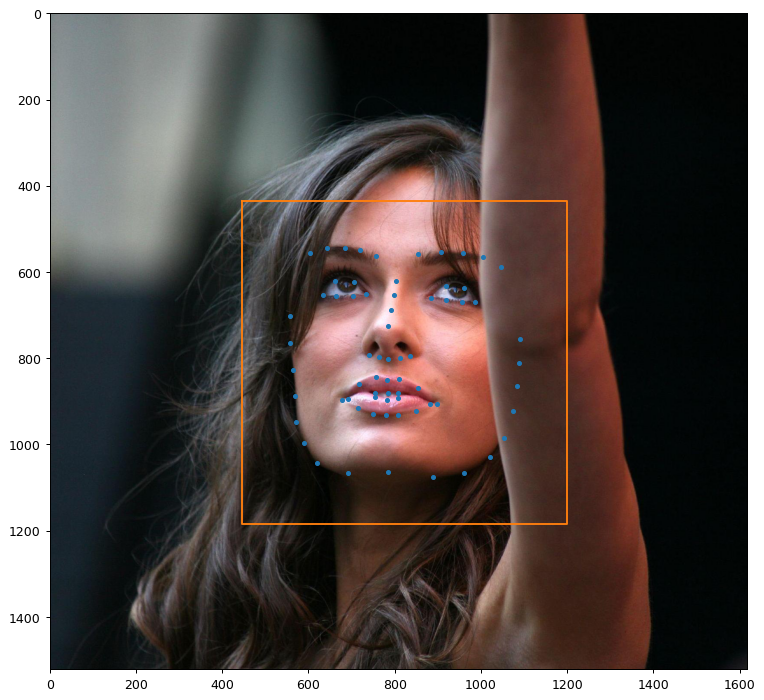

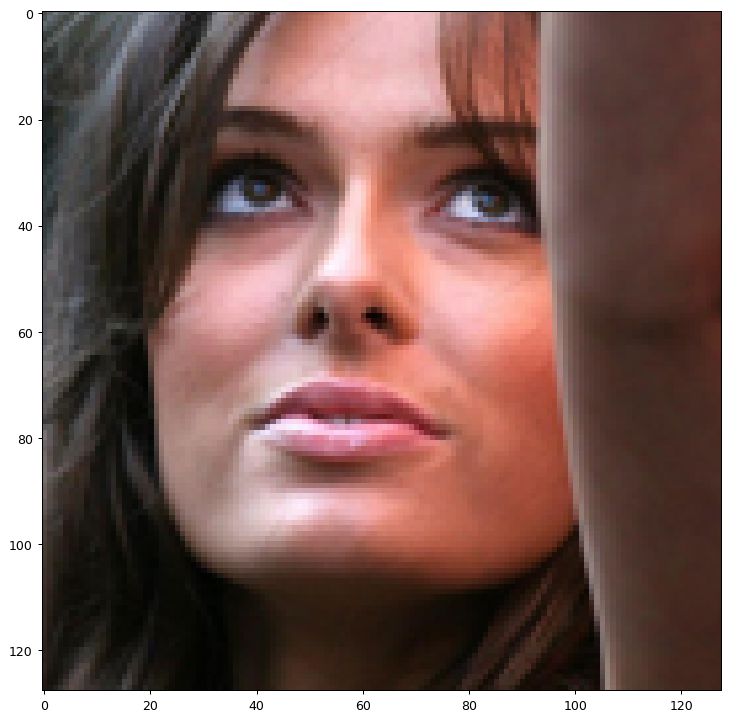

In [33]:
im = Image.open("/content/data_300/"+line[0])

plt.figure(figsize=(10, 10), dpi=90)
plt.imshow(im);plt.plot(descript_x[0],descript_y[0],'.');plt.plot(carre_x[0],carre_y[0])
plt.figure(figsize=(10, 10), dpi=90)

#on zoom sur le cadre de visage
plt.imshow(img_cope[0])

## 1.3.3

Ce code redimensionner les coordonnées des points de repère du visage pour un ensemble d'images afin qu'elles tiennent dans une image de 128x128 pixels.

Le code calcule d'abord les coordonnées x et y minimales et maximales des points de repère faciaux pour chaque image, puis utilise ces valeurs pour normaliser les coordonnées. Pour ce faire, il soustrait les coordonnées x et y minimales de chaque coordonnée, puis met les valeurs résultantes à l'échelle de la largeur et de la hauteur de l'image 128x128, respectivement. Enfin, le code convertit les coordonnées normalisées en nombres entiers à l'aide de la fonction int.

Après l'exécution de ce code, les coordonnées des points de repère du visage pour chaque image seront remises à l'échelle de façon à ce qu'elles tiennent dans une image de 128x128 pixels, avec les coordonnées x et y minimales et maximales mappées sur les bords de l'image.
 

In [34]:
for i in range (len(line)):
  min_x = min(descript_x[i])*0.8
  max_x = max(descript_x[i])*1.1
  min_y = min(descript_y[i])*0.8
  max_y = max(descript_y[i])*1.1

  for j in range (len(descript_x[i])):
     descript_x[i][j]=int ((descript_x[i][j] - min_x)*128 /(max_x - min_x)) 

  for k in range (len(descript_y[i])):
      descript_y[i][k]=int ((descript_y[i][k] - min_y )*128 /(max_y - min_y)) 

Ce code affichera la n-ième image de la liste img_cope et tracera les coordonnées des points de repère du visage stockés dans descript_x[n] et descript_y[n] comme des points individuels sur l'image.

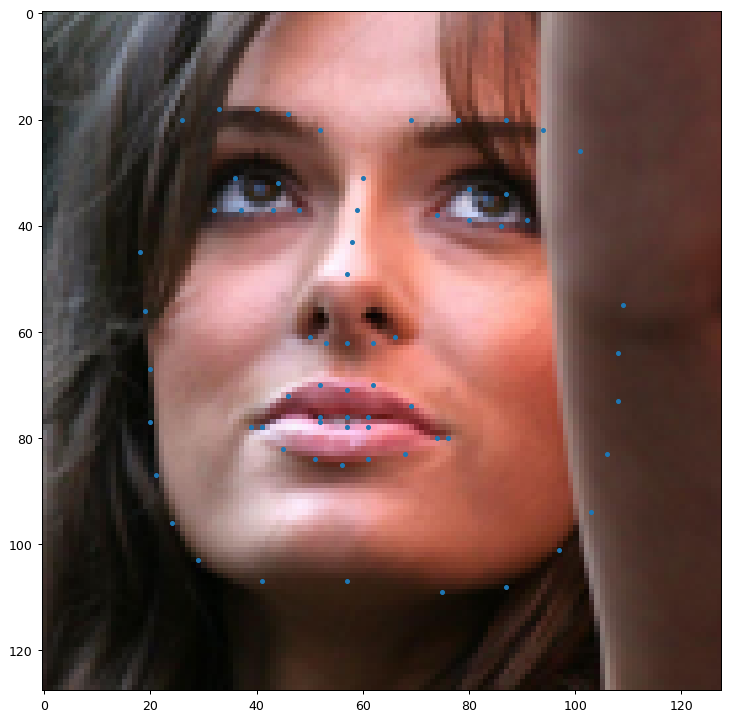

In [35]:
n=0
plt.figure(figsize=(10, 10), dpi=90);plt.imshow(img_cope[n]);
plt.plot(descript_x[n],descript_y[n],'.')

## 1.3.4 

Ce code calcule la moyenne des coordonnées des points de repère du visage pour chaque image de la liste de lignes, et stocke les résultats dans deux listes appelées x_moy et y_moy. Les coordonnées moyennes x et y de la n-ième image sont accessibles en utilisant respectivement x_moy[n] et y_moy[n].

In [36]:
x_moy, y_moy=[],[]
for k in range (len(line)):
  x_moy.append(np.mean(descript_x[k]))
  y_moy.append(np.mean(descript_y[k]))
print("La position moyenne des coordonnées des points de repère du visage est: \n x_moy = ",x_moy[n],"\n y_moy = ",y_moy[n])

La position moyenne des coordonnées des points de repère du visage est: 
 x_moy =  59.779411764705884 
 y_moy =  60.161764705882355


## 1.3.5

Ce code génère 10 perturbations aléatoires des coordonnées des points de repère du visage pour chaque image de la liste de lignes, et stocke les coordonnées perturbées résultantes dans deux listes appelées perturbations_x et perturbations_y.

Le code utilise une boucle imbriquée pour générer les perturbations. Il boucle d'abord sur les images de la liste de lignes, puis génère 10 perturbations pour chaque image à l'aide d'une boucle imbriquée. Pour chaque perturbation, le code génère un entier aléatoire entre -20 et 20, et ajoute cette valeur aux coordonnées x et y de chaque repère facial. Les coordonnées perturbées sont ensuite stockées dans les tableaux prediction_x et prediction_y, qui sont à leur tour ajoutés aux listes perturbations_x et perturbations_y.

Les listes perturbations_x et perturbations_y qui en résultent contiennent 10 ensembles de coordonnées perturbées pour chaque image de la liste de lignes, avec une forme de (68, 10) pour chaque ensemble de coordonnées. Vous pouvez utiliser ces coordonnées perturbées à diverses fins, comme l'entraînement ou l'évaluation d'un modèle de détection des points de repère du visage.

In [37]:
prediction_x, prediction_y = np.zeros((68,10)),  np.zeros((68,10))
perturbations_x, perturbations_y = [], []
for k in range (len(line)):
  for j in range(10):
      for i in range (68):
          noise= random.randint(-int(20*100/128),int(20*100/128))
          prediction_x[i][j]= descript_x[k][i] + noise
          prediction_y[i][j]= descript_y[k][i] + noise
  perturbations_x.append(prediction_x)
  perturbations_y.append(prediction_y)
print (np.shape(perturbations_x))
print (np.shape(perturbations_y))


(3148, 68, 10)
(3148, 68, 10)


Il existe plusieurs façons de déterminer automatiquement les amplitudes des perturbations appliquées aux coordonnées des points de repère du visage. Voici quelques options que vous pouvez envisager :

*  Calculer l'écart-type des coordonnées d'origine : Une option consiste à calculer l'écart type des coordonnées d'origine et à utiliser cette valeur comme amplitude maximale des perturbations. Cela garantit que les perturbations ont une échelle similaire à celle des coordonnées d'origine, et peut être ajusté en multipliant l'écart-type par un facteur d'échelle.

*  Utiliser un pourcentage fixe de la taille de l'image : Une autre option consiste à utiliser un pourcentage fixe de la taille de l'image comme amplitude maximale pour les perturbations. Par exemple, vous pouvez utiliser 10 % de la largeur ou de la hauteur de l'image comme amplitude maximale de la perturbation. Cette approche est simple à mettre en œuvre et vous permet de contrôler facilement l'ampleur des perturbations.

*  On peut utiliser un modèle de régression linéaire pour déterminer automatiquement les amplitudes des perturbations appliquées aux coordonnées des points de repère du visage.

# **2 Apprentissage d’un régresseur simple**

### **2.1 Extraction de caractéristiques image :**


### 1.
**Il y a plusieurs raisons pour lesquelles il peut ne pas être pratique d'utiliser directement les valeurs des pixels d'une image comme représentation :**

**Haute dimensionnalité :** Les images peuvent avoir un grand nombre de pixels, généralement des centaines ou des milliers, ce qui donne une représentation à haute dimension. Cela peut rendre difficile le traitement et l'analyse des données, car de nombreux algorithmes d'apprentissage automatique ont tendance à être peu performants avec des données à haute dimension.

**Caractéristiques non pertinentes :** Les valeurs des pixels d'une image ne sont pas toujours pertinentes pour la tâche à accomplir. Par exemple, si vous essayez de détecter les points de repère du visage, les valeurs des pixels peuvent ne pas correspondre directement à la position des points de repère et peuvent contenir beaucoup d'informations non pertinentes telles que l'arrière-plan ou d'autres objets dans l'image.

**Bruit et variabilité :** Les valeurs de pixel d'une image peuvent être affectées par divers facteurs, tels que les conditions d'éclairage, les propriétés de la caméra et les techniques de traitement d'image, qui peuvent introduire du bruit et de la variabilité dans les données. Il peut alors être difficile d'extraire des caractéristiques significatives des valeurs des pixels.


inspirer de cette Ref: http://www.map.toulouse.archi.fr/works/panoformation/imagenum/imagenum.htm

## **2.** 

Ce code crée une liste d'objets cv2.KeyPoint pour les coordonnées du point de repère facial de chaque image de la liste de lignes.

La classe cv2.KeyPoint fait partie de la bibliothèque cv2 et représente un point clé ou une caractéristique dans une image. Elle possède plusieurs attributs, tels que les coordonnées x et y, la taille et l'orientation, qui peuvent être utilisés pour décrire le point clé.

Dans ce code, les objets cv2.KeyPoint sont créés en utilisant les coordonnées x et y des points de repère du visage, et une taille de 20. Les objets cv2.KeyPoint sont ensuite ajoutés à une liste appelée keypoint.

Enfin, la liste keyp est transformée en un tableau 2D à l'aide de la fonction reshape de NumPy, et le tableau résultant a une forme de (len(ligne), 68). Ce tableau peut être utilisé pour stocker les objets cv2.KeyPoint pour chaque image, et on peut y accéder en utilisant les indices keypoint[k][i], où k est l'indice de l'image et i est l'indice du keypoint.

In [38]:
keypoint=[]
for k in range (len(line)):
  for i in range (68):
      key=cv2.KeyPoint(descript_x[k][i], descript_y[k][i],20)
      keypoint.append(key)
   
keypoint=np.reshape(keypoint,(len(line),68))
np.shape(keypoint)

(3148, 68)

## 3. 
Ce code calcule le descripteur SIFT (Scale Invariant Feature Transform) pour chaque image de la liste de lignes, et stocke les descripteurs résultants dans une liste appelée decripteur.

Le descripteur SIFT est un descripteur qui est utilisé dans de nombreuses tâches de vision par ordinateur, telles que la reconnaissance d'objets et la correspondance d'images.  

Pour calculer le descripteur SIFT, le code lit d'abord les données de l'image à partir d'un fichier appelé "image.jpg" en utilisant la fonction imread de cv2. L'image est ensuite convertie en niveaux de gris à l'aide de la fonction cvtColor, et un objet SIFT est créé à l'aide de la fonction SIFT_create. Enfin, la méthode de calcul de l'objet SIFT est utilisée pour calculer le descripteur des points clés de l'image.

Le descripteur SIFT résultant est un tableau à 128 dimensions, qui est stocké dans la liste de descripteurs. La liste de descripteurs contient un descripteur SIFT pour chaque image de la liste de lignes, avec une forme de (128,) pour chaque descripteur. Vous pouvez utiliser les descripteurs SIFT pour représenter les caractéristiques des images, ou comme entrée pour divers algorithmes de vision par ordinateur qui peuvent traiter les descripteurs de caractéristiques.

In [39]:
descripteur=[]
for i in range (len(line)):
  img_cope[i].save("image.jpg")
  img = cv2.imread ('image.jpg')
  gray= cv2.cvtColor (img,cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT_create()
  i,k= sift.compute(gray,keypoint[1])
  descripteur.append(k)
  
print("La dimension de chacun des descripteur est :",np.shape(descripteur))

La dimension de chacun des descripteur est : (3148, 68, 128)


## 4.
Ce code concatène les éléments de la liste descripteur dans une nouvelle liste appelée descripteurs. La boucle for parcourt chaque élément de la liste line et ajoute à la liste descripteurs la concaténation de l'élément correspondant de descripteur

In [40]:
"Concatenation des descripteur"
descripteurs=[]
for i in range (len(line)):
  descripteurs.append(np.concatenate(descripteur[i]))
print("La dimension de ce descripteur est ",np.shape(descripteurs))

La dimension de ce descripteur est  (3148, 8704)


## 5. 
**Voici deux exemples de représentations d'images qui pourraient être utilisées à la place des descripteurs SIFT:**

* **Les histogrammes de gradients orientés (HOG)**: Ces représentations d'images se basent sur l'analyse des gradients d'intensité de l'image. Elles sont souvent utilisées pour la détection d'objets dans les images. 

* **Les descripteurs de texture** : Ces représentations d'images sont basées sur l'analyse de la texture de l'image. Elles sont souvent utilisées pour la reconnaissance de texture ou pour la segmentation d'image.

## **2.2 Réduction de dimensionalité**

## **1.**
**L'intérêt principal de la réduction de dimensionalité en machine learning est de réduire la complexité du modèle et d'améliorer les performances de l'apprentissage automatique.**

**Voici quelques avantages de la réduction de dimensionalité :**

* **Réduction de la complexité du modèle** : Lorsqu'un modèle a un grand nombre de dimensions (ou de caractéristiques), il peut être difficile à entraîner et à interpréter.  
* **Amélioration des performances de l'apprentissage automatique**. 

* **Visualisation des données**. 

**Voici quelques exemples de méthodes de réduction de dimensionalité couramment utilisées en machine learning :**

* **Analyse en composantes principales (ACP)**.  

* **Analyse de correspondance multiples (MCA)**. 

* **Réduction par projection :** Cette méthode consiste à projeter les données sur un sous-espace de dimensions inférieures en utilisant une transformation linéaire.  
* **Réduction par clustering :** Cette méthode consiste à regrouper les données en différents clusters et à ne conserver qu'une seule dimension pour chaque cluster. Elle peut être utilisée

In [41]:
from sklearn.decomposition import PCA

Dans ce code la ligne pca = PCA(0.98) crée un objet PCA avec un paramètre de décision de 98%. Cela signifie que l'objet PCA essaiera de conserver 98% de l'information contenue dans les données lors de la réduction de dimensionnalité.

La ligne descripteur_reduit=pca.fit_transform(descripteurs) utilise l'objet PCA pour réduire la dimensionnalité de l'ensemble de données descripteurs et enregistre le résultat dans la variable descripteur_reduit. La méthode fit_transform() permet de calculer les composantes principales des données et de les utiliser pour transformer les données d'origine en données réduites.

In [44]:
pca = PCA(0.98)
descripteur_reduit=pca.fit_transform(descripteurs)
print("La dimension des anciens descripteurs est :", np.shape(descripteur))
print("La dimension des nouveaux descripteurs est :", np.shape(descripteur_reduit))

La dimension des anciens descripteurs est : (3148, 68, 128)
La dimension des nouveaux descripteurs est : (3148, 240)


## **2. Estimation du déplacement**

**1. Calculer la matrice Y0**

Dans ce code, Y0 est une matrice de taille (len(descripteur_reduit), len(descripteur_reduit[1])+1) qui contient les données de descripteur_reduit et une colonne supplémentaire de valeurs 1. La boucle for permet de parcourir chaque élément de descripteur_reduit et de le copier dans Y0.

Plus précisément, la ligne Y0 = np.ones( (len(descripteur_reduit) , len(descripteur_reduit[1])+1 )) crée une matrice de valeurs 1 de taille (len(descripteur_reduit), len(descripteur_reduit[1])+1).  

In [47]:
Y0 = np.ones( (len(descripteur_reduit) , len(descripteur_reduit[1])+1 ))

for i in range (len(descripteur_reduit)):
  for j in range (len(descripteur_reduit[1])):
      Y0[i][j]=descripteur_reduit[i][j]
print(np.shape(Y0))

(3148, 241)


## **2. Calculer R0**

Dans ce code, le modèle linéaire est défini par la fonction model(), qui prend en entrée une variable indépendante x et les paramètres a et b, et qui retourne la valeur prédite de la variable cible y en utilisant la formule y = ax + b.

La fonction lstsq() de la bibliothèque NumPy est utilisée pour trouver les paramètres a et b qui minimisent l'erreur quadratique moyenne entre les valeurs prédites par le modèle et les valeurs observées. Elle prend en entrée les matrices Y0[1] et Y0[0] et retourne un tuple qui contient les paramètres a et b. Ces paramètres sont affectés à la variable a et b, respectivement.

In [ ]:
"""
import numpy as np

# modèle linéaire sous la forme y = ax + b
def model(x, a, b):
  return a * x + b

# la fonction lstsq() de NumPy pour trouver les paramètres a et b qui minimisent l'erreur quadratique moyenne entre le modèle et les données d'apprentissage
a, b = np.linalg.lstsq(Y0[1], Y0[0], rcond=None)[0]

# Créez une matrice Y en appliquant les paramètres a et b à chaque ligne de X
Y = model(Y0[1], a, b)
"""



## **3. Calcule de l’erreur**

In [ ]:
 """
 # Créez les matrices de points s0 et s0_displaced
s0 = np.array([[1, 2], [3, 4], [5, 6]])
s0_displaced = np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6]])

# Calculez l'erreur entre s0 et s0_displaced
error = s0_displaced - s0

# Affichez les points s0 en vert et les points s0_displaced en rouge sur l'image
for point in s0:
  cv2.circle(img, tuple(point), 3, (0, 255, 0), -1)
for point in s0_displaced:
  cv2.circle(img, tuple(point), 3, (0, 0, 255), -1)

# Affichez l'image
cv2_imshow('img', image)
"""

# **2.4 Validation sur un ensemble de test externe**

## 1. 
**En quoi l’évaluation précédente n’est-elle pas pertinente pour évaluer la capacité de généralisation de la procédure d’alignement de points caractéristiques?**

* L'évaluation précédente ne mesure pas la capacité de généralisation de la procédure d'alignement de points caractéristiques, c'est-à-dire sa capacité à fonctionner de manière fiable sur des données inconnues.

* si la procédure d'alignement de points caractéristiques a été entraînée et testée sur les mêmes images, elle n'a pas été testée sur des images inconnues et il est donc difficile de dire si elle sera capable de fonctionner de manière fiable sur d'autres ensembles de données.

$$
\text { 2. Calculer l'erreur } \delta_s^*-R_0 \tilde{\mathbf{Y}}_0
$$

Dans cet exemple, delta_s est la matrice de l'erreur entre les points caractéristiques déplacés et leur position attendue, R0 est la matrice de rotation et Y0 est la matrice des points caractéristiques.

In [ ]:
#error = delta_s - R0 @ Y0 